# Decision Tree

Decision trees are constructed from only two elements — nodes and branches.

* Root node: The node at the top of the tree is called root. It contains a feature that best splits the data.

* Decision nodes: The nodes where the variables are evaluated. These nodes have arrows pointing to them and away from them.

* Leaf nodes: The final nodes at which the prediction is made.

For example refer to the image shown below.

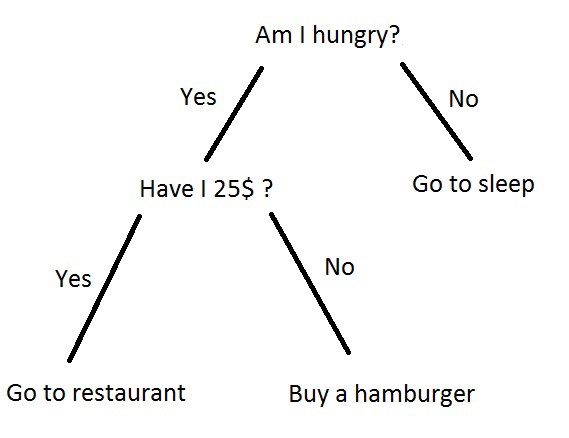

## Math Behind Decision Trees

For Decision trees we only have to implement two formulas for the learning part — entropy and information gain.


### Entropy

Entropy measures a purity of a split at a node level. Its value ranges from 0 (pure) and 1 (impure).

Formula for Entropy:

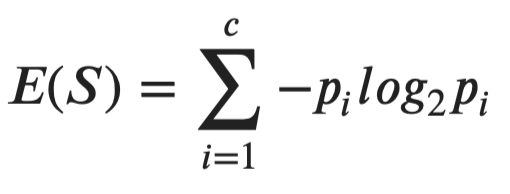

For example you want to calculate the purity of the following vector:

s = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

Zeros and ones are the class labels with the following counts:

n0 = 7
n1 = 3

Calculation for entropy:

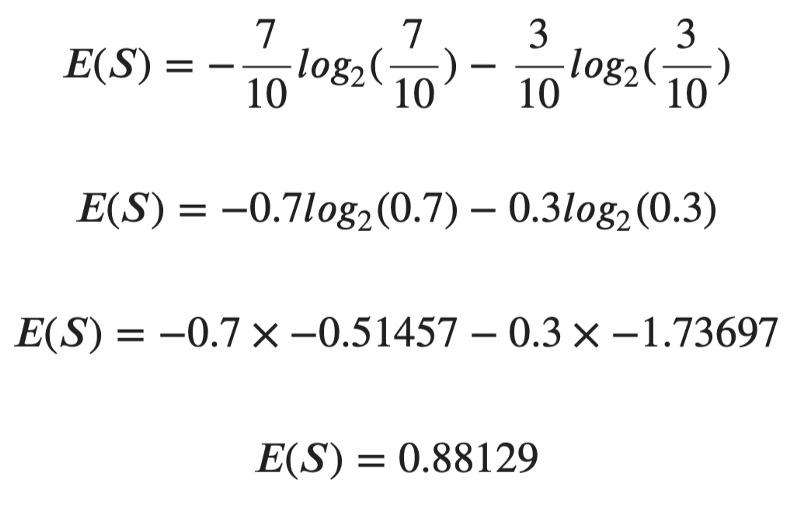

In [1]:
import numpy as np
from collections import Counter


def entropy(s):
    counts = np.bincount(s)
    percentages = counts / len(s)
    
    entropy = 0
    for pct in percentages:
        if pct > 0:
            entropy += pct * np.log2(pct)
    return -entropy

s = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
print(f'Entropy: {np.round(entropy(s), 5)}')

Entropy: 0.88129


### Information gain

It represents an average of all entropy values based on a specific split. The higher the information gain value, the better the decision split is.

Information gain can be calculated with the following formula:

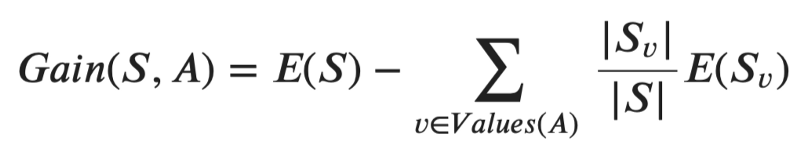

Information gain calculation: 

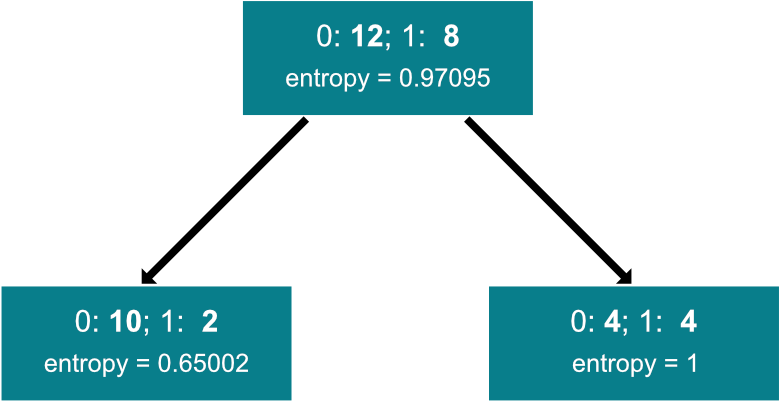

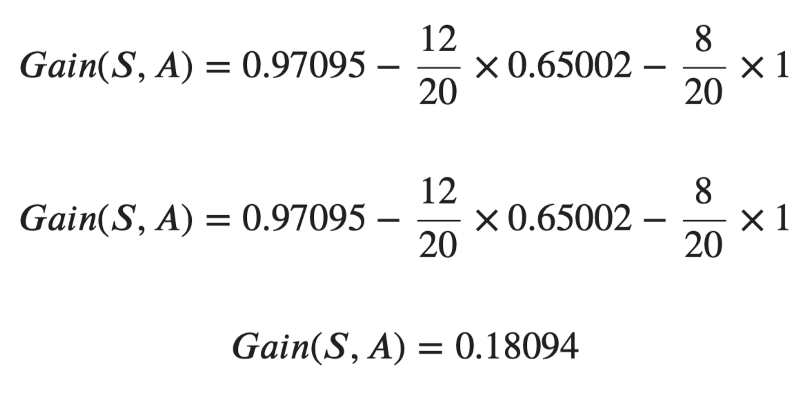

In [2]:
def information_gain(parent, left_child, right_child):
    num_left = len(left_child) / len(parent)
    num_right = len(right_child) / len(parent)
    
    gain = entropy(parent) - (num_left * entropy(left_child) + num_right * entropy(right_child))
    return gain

parent = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
left_child = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
right_child = [0, 0, 0, 0, 1, 1, 1, 1]

print(f'Information gain: {np.round(information_gain(parent, left_child, right_child), 5)}')

Information gain: 0.18094


# Implementation

We’ll need two classes:

* Node – implements a single node of a decision tree
* DecisionTree – implements the algorithm

In [3]:
class Node:
    '''
    Class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [4]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Calculates entropy from an array of integer values.
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Calculates information gain from a parent and two child nodes.
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
    
    def _best_split(self, X, y):
        '''
        Calculates the best split for given features and target
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Recursive function, used to build a decision tree from the input data.
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Recursive function, used to predict a single instance (tree traversal).
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

### Model Evaluation

We’ll use the Iris dataset from Scikit-Learn. The following code snippet loads the dataset and separates it into features (X) and the target (y):

In [5]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris['data']
y = iris['target']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = DecisionTree()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [8]:
def r2_score(y, y_hat):
    return 1 - (np.sum((np.array(y_hat)-np.array(y))**2)/
                np.sum((np.array(y)-np.mean(np.array(y)))**2))

In [9]:
print("R2 score of our model is : ",r2_score(y_test,preds))

R2 score of our model is :  1.0


In [10]:
def accuracy(y,yhat):
    return 1-np.sum(np.abs(np.array(y).reshape(-1,1)-np.array(yhat).reshape(-1,1)))/len(y)

In [11]:
print("Accuracy of our model is : ",accuracy(y_test,preds))

Accuracy of our model is :  1.0
